<a href="https://colab.research.google.com/github/sidgodb/blog/blob/master/SiddharthGodbole_MiniTask2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minitask 2 - ADAMS Next Top Model 

> Identifying and predicting the star rating after analysing the reviews 

**Contributors:**
>Siddharth Godbole (601552)
<br> Toby Chelton (601819)
<br>Veronika Simoncikova (601550)



# Loading the data and packages

In [ ]:
#setup code
#main packages from Ex.4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re #regular expressions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

#for word tokenization
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

import keras
from keras.models import Sequential
# we will need to import some core layers and some utilities
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

from __future__ import print_function
from nltk.stem import *


Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#setup code
#code to load in data https://medium.freecodecamp.org/how-to-transfer-large-files-to-google-colab-and-remote-jupyter-notebooks-26ca252892fa

!pip install pydrive #if needed

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#the file is public so this works for any Google Drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


     |████████████████████████████████| 993kB 3.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


**Uploading the datasets**
We have upload all the training and testing datasets MC2 and MC2test.csv 
<br> Along with that we are using **Glove** dataset. This Glove dataset has been downloaded and then uploaded back. There are various different versions of Glove that we could use - different sizes and sources. What we have here is 6 billion words each represented as 100 length vector.  

In [ ]:
#setup code
#code to tell Colab what to import from Google Drive
train = drive.CreateFile({'id': '1ylh9tt89V3nezuOKUxxQMDPb1kizngdP'})
train.GetContentFile('MC2.csv')

test = drive.CreateFile({'id': '1d9JqCjNb-AXh25Pi-i6Hf94SXsueXF5s'})
test.GetContentFile('MC2test.csv')


glove = drive.CreateFile({'id': '1fx_E-moM2aUJsdQ4KRC2zRQPE3fxfGEj'})
glove.GetContentFile('glove.6B.100d.txt')

#setup code
#reading in data as a pandas dataframe

train = pd.read_csv('MC2.csv')
test=pd.read_csv('MC2test.csv')





W0630 08:04:51.322088 139685384861568 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

# Exploring the dataset

<br> The data given to use includes different fields liked product_id, product_title, star_rating, helpful_votes, total_votes, verified_purchases and ofcourse the review_headline and review_body. 
<br> Our aim is to predict the star_rating based on the different fields provided to us. 

In [ ]:
train.head(6)

,Unnamed: 0,product_id,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
0,1,0983797706,Igniting Your True Purpose and Passion: A Busi...,5,0,0,N,This is an inspirational and insightful book t...,This is an inspirational and insightful book t...
1,2,1423151283,The Duckling Gets a Cookie!? (Pigeon),5,0,0,N,Loved it!,My twins are 3 and they love the pigeon books!...
2,3,1445604752,Spitfire Ace of Aces: The Wartime Story of Joh...,4,2,2,N,Engaging Account of the Combat Career of an RA...,"Back in 1964, I was introduced to 'Johnnie' Jo..."
3,4,0393057941,The Bread Bible,5,0,0,N,Great book for beginners,I disagree with those reviews that say this is...
4,5,1608322858,Do It Well. Make It Fun.: The Key to Success i...,3,2,2,N,Left me wanting more,"Reading this book, I hoped to find more about ..."
5,6,B001FVQAPW,Myth and Christianity: An Inquiry into the Pos...,5,3,3,N,"A ""SEMI-DIALOGUE"" BETWEEN TWO TOWERING 20TH CE...",Rudolf Bultmann (1884-1976) was a German theol...


> In the given dataset, the number of reviews receiving 5 star rating is much higher compared to the other ratings. However, we are dealing with a dataset which has a great amount of data and hence, our modeling approach should be able to handle this. 

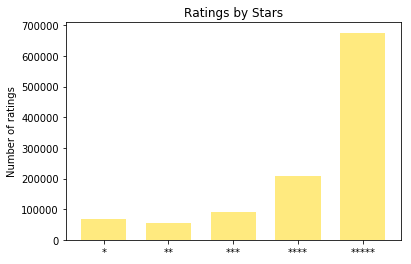

In [ ]:
plt.hist(train.star_rating, bins=5,alpha=0.5, color='gold', rwidth=0.7) #density=True if want to see probability of a rating
plt.xticks([1.4,2.2,3,3.8,4.6],['*','**', '***','****','*****'])
plt.ylabel('Number of ratings')
plt.title("Ratings by Stars")

plt.show()

#most reviews have 5 stars

## Data Preparation

> Checking the total number of rows, cleaning the text involving processes like removing stop words, lower casing everything, lemmatization and stemming. This is to make the text processing easier. 

In [ ]:
train.shape
#the dataset has over 1 million rows

(1099209, 9)

There's a great amount of data (over 1 million) -  let's start by just working with a small part of the train set in order to speed up computation, say 10 percent. 



For going ahead with our analyses, we tried doing two approaches : 

<br> 1. Analysis entirely with review_body.
- Although the review_title idea sounds promising, many times people write detailed and descriptive reviews and then give a star_rating. 
- In this case, analysing the entire review_body would make more sense. 

<br> 2. Analysing entirely with review_headline 
- Our understanding in this case was that it has a shorter length and hence computationally less intense. 
- People normally would have the 'exact' emotion out when writing the review_headline making it easy to link to the star_rating 



In [ ]:
#10 percent of data
train2 = train.sample(100000,random_state=123,axis=0)

train2=train2[["star_rating","review_body"]]
train2.review_body=train2.review_body.astype(str)
train2.star_rating=train2.star_rating.astype(str)


Before we do anything, we must set some test data aside

In [ ]:
from sklearn.model_selection import train_test_split
train ,test = train_test_split(train2, test_size=0.30, random_state=9)

train.shape


(70000, 2)

We switch to the conventional notation for feature(s) (=X) and target (=Y):

In [ ]:
X=train['review_body']
y=train['star_rating']

**Cleaning data:**
<br>The following code is for cleaning the content of each review text that we encounter. This could be applied for 'review_body' or 'review_head' .
<br> It removes punctuation (even though in theory this could be informative, especially exclamation marks), stop words, very short words and then some common strings that are unlikely to hold semantic information. 
<br>
When we then test our model at the end, we'll also need to apply this 'clean_text' function on the test data.

In [ ]:
def clean_text(text):
    
    ## Remove punctuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text) 
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text
# apply the above function to df['text']
X= X.map(lambda x: clean_text(x))


Here we represent the score out of 5 as a one-hot encoded array.


In [ ]:
y=pd.get_dummies(y)
y=y.values

The keras tokenizer is one way to tokenize the review text into a sequence of integers

<br>
'maxlen' in the pad_sequences function controls how many words we allow to be included in a review. 

In [ ]:
### Create sequence
vocabulary_size = 50000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen=100)

In [ ]:
X.shape

(70000, 100)

Splitting the training and test dataset over here. In this case, X_val and y_val are our test datasets which will given as validation data input for keras to test for accuracy. 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=9)

X_val.shape

(21000, 100)

## Model Architecture - Review_Body

Now that our data is cleaned and in the right shape, we start building model architecture (starting with small number of epochs). Our first basic model includes an embedding layer that is transforming the word token integers into a 100-length vector representation, and Keras tokenizer.
<br>
In this model the embeddings are trained at the same time as everything else.<br>
In all following models, we use *Softmax* as an activation function in the last layer, which will assign each review a range of probabilities for each rating, with 5* being the target. <br>
Moreover, we use *categorical crossentropy* as a loss function because our goal is non-binary classification. <br>
We chose *adam* as the optimizer because it is straightforward to implement, computationally efficient and has little memory requirement

In [ ]:
model = Sequential()
model.add(Embedding(50000, 100, input_length=100))
model.add(LSTM(200, dropout=0.5, recurrent_dropout=0.2)) #originally dropout=0.2, but was hugely overfitting
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit the model
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 30, batch_size=3000)

Train on 49000 samples, validate on 21000 samples
Epoch 1/30
49000/49000 [==============================] - 10s 198us/step - loss: 1.3277 - acc: 0.5883 - val_loss: 1.1587 - val_acc: 0.6075
Epoch 2/30
49000/49000 [==============================] - 8s 172us/step - loss: 1.1149 - acc: 0.6166 - val_loss: 1.0932 - val_acc: 0.6075
Epoch 3/30
49000/49000 [==============================] - 9s 174us/step - loss: 1.0238 - acc: 0.6205 - val_loss: 1.0042 - val_acc: 0.6143
Epoch 4/30
49000/49000 [==============================] - 9s 175us/step - loss: 0.9320 - acc: 0.6367 - val_loss: 0.9759 - val_acc: 0.6243
Epoch 5/30
49000/49000 [==============================] - 9s 174us/step - loss: 0.8860 - acc: 0.6490 - val_loss: 0.9519 - val_acc: 0.6287
Epoch 6/30
49000/49000 [==============================] - 8s 172us/step - loss: 0.8459 - acc: 0.6619 - val_loss: 0.9505 - val_acc: 0.6295
Epoch 7/30
49000/49000 [==============================] - 8s 172us/step - loss: 0.8147 - acc: 0.6728 - val_loss: 0.9625 -

In [ ]:
#Saving this model

model.save('model.h5')
model_file = drive.CreateFile({'title' : 'model_1.h5'}) 

The model above reached accuracy on validation set around 60%, but is overfitting (performing much better on the in-sample test set).

We also tried adding a few more layers including a pooling layer, 'relu' activation layer and made the network more dense. The results are better than the network built before.


In [ ]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length=100))
    model_conv.add(Dropout(0.2)) #originally dropout=0.2
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=5)) #originally pool_size=4
    model_conv.add(LSTM(100))
    model_conv.add(Dense(5, activation='softmax'))
    model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_conv
model_conv = create_conv_model()
model_conv.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 8, batch_size=3000)

Train on 49000 samples, validate on 21000 samples
Epoch 1/8
49000/49000 [==============================] - 4s 86us/step - loss: 1.3346 - acc: 0.5826 - val_loss: 1.1468 - val_acc: 0.6075
Epoch 2/8
49000/49000 [==============================] - 2s 34us/step - loss: 1.1268 - acc: 0.6166 - val_loss: 1.1239 - val_acc: 0.6075
Epoch 3/8
49000/49000 [==============================] - 2s 34us/step - loss: 1.0807 - acc: 0.6166 - val_loss: 1.0672 - val_acc: 0.6075
Epoch 4/8
49000/49000 [==============================] - 2s 34us/step - loss: 0.9988 - acc: 0.6167 - val_loss: 1.0050 - val_acc: 0.6087
Epoch 5/8
49000/49000 [==============================] - 2s 34us/step - loss: 0.9214 - acc: 0.6313 - val_loss: 0.9691 - val_acc: 0.6194
Epoch 6/8
49000/49000 [==============================] - 2s 35us/step - loss: 0.8461 - acc: 0.6608 - val_loss: 0.9463 - val_acc: 0.6327
Epoch 7/8
49000/49000 [==============================] - 2s 35us/step - loss: 0.7827 - acc: 0.6835 - val_loss: 0.9589 - val_acc: 0.626

We decided to try the combination of epochs and batch size and try to see the most optimal combination to use. A more ideal approach in this case would be to use a grid search and go ahead. 
In this model, accuracy of training set is ~71% and one our testing set is 63%. It sill shows a bit of discrepancy. 

We use the glove embeddings in our model to understand if using already available word embeddings could be helpful.

In [ ]:
embeddings_index = dict()
import io
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Here's how it knows how to match the tokenised words with the correct embeddings:

In [ ]:
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

And this is how it looks with the Embedding layer that uses the embeddings from Glove: 

In [ ]:
## create model
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=100, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=5)) #originally 4
model_glove.add(LSTM(100))
model_glove.add(Dense(5, activation='softmax')) #originally sigmoid
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
history=model_glove.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 30, batch_size=2000)

Train on 49000 samples, validate on 21000 samples
Epoch 1/30
49000/49000 [==============================] - 4s 84us/step - loss: 1.2144 - acc: 0.5897 - val_loss: 1.1471 - val_acc: 0.6075
Epoch 2/30
49000/49000 [==============================] - 2s 31us/step - loss: 1.1200 - acc: 0.6167 - val_loss: 1.1203 - val_acc: 0.6083
Epoch 3/30
49000/49000 [==============================] - 2s 31us/step - loss: 1.0879 - acc: 0.6171 - val_loss: 1.1077 - val_acc: 0.6006
Epoch 4/30
49000/49000 [==============================] - 2s 31us/step - loss: 1.0578 - acc: 0.6176 - val_loss: 1.0479 - val_acc: 0.6104
Epoch 5/30
49000/49000 [==============================] - 2s 31us/step - loss: 1.0333 - acc: 0.6207 - val_loss: 1.0499 - val_acc: 0.6077
Epoch 6/30
49000/49000 [==============================] - 2s 31us/step - loss: 1.0189 - acc: 0.6216 - val_loss: 1.0403 - val_acc: 0.6040
Epoch 7/30
49000/49000 [==============================] - 2s 31us/step - loss: 1.0025 - acc: 0.6255 - val_loss: 1.0088 - val_acc

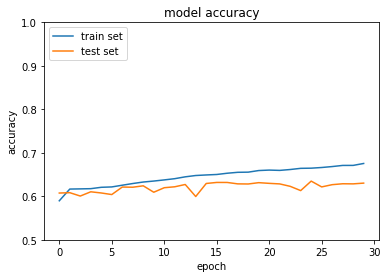

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.yscale('linear')
plt.ylim((0.5,1))
plt.xlabel('epoch')
plt.legend(['train set', 'test set'], loc='upper left')
plt.show()

> In this case for the given epoch-batch size combination, Glove performs better than the previous models we built. We observe that even by using a high number of epochs the difference between training set and test set accuracy is ~ 4%

## Building a benchmark model - Logistic regression - Review_Body


Even though we have access to Glove, gensim and other embeddings, we may be able to build more simplistic models by using logistic regression and count vectorizer. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train2['review_body'],train2['star_rating'], test_size=0.30, random_state=9)



In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

import warnings 
warnings.filterwarnings('ignore')

classifier = LogisticRegression(solver="lbfgs", multi_class="multinomial", max_iter=500)
classifier.fit(X_train, y_train)
score_lr = classifier.score(X_test, y_test)

print("Accuracy:", score_lr)

Accuracy: 0.6504333333333333


## Model Architecture and Accuracies - Review_Headline

- We perfom the same analysis on review_headline to observe for any changes in the model parameters or accuracy.



In [ ]:
#Uploading the original train dataset
train = pd.read_csv('MC2.csv')

In [ ]:
#Since the review_title is not so computationally heavy to handle we go for 50% of the dataset rows from review_title.
#10 percent of data

train2 = train.sample(500000,random_state=123,axis=0)

train2=train2[["star_rating","review_headline"]]
train2.review_headline=train2.review_headline.astype(str)
train2.star_rating=train2.star_rating.astype(str)

In [ ]:
#Splitting the data in train and test for our analyses like review_body.

from sklearn.model_selection import train_test_split
train ,test = train_test_split(train2, test_size=0.30, random_state=9)

train.shape


(350000, 2)

Setting the conventional notations for dependent and independent variables. 

In [ ]:
X=train['review_headline']
y=train['star_rating']

In [ ]:
#Cleaning the review_title data
def clean_text(text):
    
    ## Remove punctuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text) 
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text



X= X.map(lambda x: clean_text(x))

In [ ]:
#Representing the dummy encoding 
y=pd.get_dummies(y)
y=y.values

In [ ]:
### Create sequence of word tokens, with maximum length=50. 
#Since it is review_title we believe a less length should work for review_titles

vocabulary_size = 50000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen=50)

X.shape

(350000, 50)

In [ ]:
#Splitting our 50% data into further training and test 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=9)

X_val.shape

(105000, 50)

In [ ]:
#Building a sequential model 

model = Sequential()
model.add(Embedding(50000, 100, input_length=50))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2)) 
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit the model
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 25, batch_size=5000)

Train on 245000 samples, validate on 105000 samples
Epoch 1/25
245000/245000 [==============================] - 22s 89us/step - loss: 1.1827 - acc: 0.6062 - val_loss: 1.0855 - val_acc: 0.6153
Epoch 2/25
245000/245000 [==============================] - 21s 84us/step - loss: 1.0131 - acc: 0.6212 - val_loss: 0.9777 - val_acc: 0.6340
Epoch 3/25
245000/245000 [==============================] - 21s 84us/step - loss: 0.9347 - acc: 0.6463 - val_loss: 0.9399 - val_acc: 0.6494
Epoch 4/25
245000/245000 [==============================] - 20s 84us/step - loss: 0.8886 - acc: 0.6595 - val_loss: 0.9302 - val_acc: 0.6520
Epoch 5/25
245000/245000 [==============================] - 21s 84us/step - loss: 0.8630 - acc: 0.6687 - val_loss: 0.9345 - val_acc: 0.6526
Epoch 6/25
245000/245000 [==============================] - 21s 84us/step - loss: 0.8439 - acc: 0.6770 - val_loss: 0.9385 - val_acc: 0.6491
Epoch 7/25
245000/245000 [==============================] - 21s 84us/step - loss: 0.8264 - acc: 0.6850 - val

We built another deeper model with more layers and different parameters. We added 'relu' activation like the review_body model. 

In [ ]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length=50))
    model_conv.add(Dropout(0.8)) 
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=5)) #originally pool_size=4
    model_conv.add(LSTM(100))
    model_conv.add(Dense(5, activation='softmax'))
    model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_conv
model_conv = create_conv_model()
model_conv.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 20, batch_size=5000)

W0630 08:48:29.078641 139685384861568 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 245000 samples, validate on 105000 samples
Epoch 1/20
245000/245000 [==============================] - 6s 25us/step - loss: 1.1972 - acc: 0.5960 - val_loss: 1.1804 - val_acc: 0.6153
Epoch 2/20
245000/245000 [==============================] - 4s 17us/step - loss: 1.1402 - acc: 0.6143 - val_loss: 1.1687 - val_acc: 0.6153
Epoch 3/20
245000/245000 [==============================] - 4s 17us/step - loss: 1.1073 - acc: 0.6143 - val_loss: 1.1374 - val_acc: 0.6153
Epoch 4/20
245000/245000 [==============================] - 4s 17us/step - loss: 1.0729 - acc: 0.6143 - val_loss: 1.0970 - val_acc: 0.6157
Epoch 5/20
245000/245000 [==============================] - 4s 17us/step - loss: 1.0443 - acc: 0.6189 - val_loss: 1.0590 - val_acc: 0.6222
Epoch 6/20
245000/245000 [==============================] - 4s 17us/step - loss: 1.0180 - acc: 0.6234 - val_loss: 1.0278 - val_acc: 0.6311
Epoch 7/20
245000/245000 [==============================] - 4s 17us/step - loss: 0.9933 - acc: 0.6322 - val_loss: 

We use Glove embeddings for our review_headline analysis as well. 

In [ ]:
#Loading the embeddings. 
embeddings_index = dict()
import io
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
#Matching embeddings with tokenized words from review_title
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
## create model
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=5)) #originally 4
model_glove.add(LSTM(100))
model_glove.add(Dense(5, activation='softmax')) #originally sigmoid
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
history=model_glove.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 30, batch_size=2000)

Train on 245000 samples, validate on 105000 samples
Epoch 1/30
245000/245000 [==============================] - 7s 27us/step - loss: 1.1581 - acc: 0.6067 - val_loss: 1.0871 - val_acc: 0.6165
Epoch 2/30
245000/245000 [==============================] - 4s 18us/step - loss: 1.0712 - acc: 0.6211 - val_loss: 1.0506 - val_acc: 0.6277
Epoch 3/30
245000/245000 [==============================] - 4s 18us/step - loss: 1.0514 - acc: 0.6262 - val_loss: 1.0410 - val_acc: 0.6295
Epoch 4/30
245000/245000 [==============================] - 4s 18us/step - loss: 1.0413 - acc: 0.6286 - val_loss: 1.0342 - val_acc: 0.6316
Epoch 5/30
245000/245000 [==============================] - 4s 18us/step - loss: 1.0350 - acc: 0.6300 - val_loss: 1.0314 - val_acc: 0.6321
Epoch 6/30
245000/245000 [==============================] - 4s 18us/step - loss: 1.0296 - acc: 0.6302 - val_loss: 1.0304 - val_acc: 0.6325
Epoch 7/30
245000/245000 [==============================] - 4s 18us/step - loss: 1.0258 - acc: 0.6311 - val_loss: 

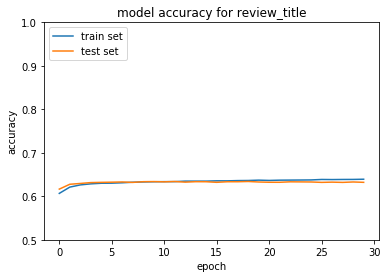

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy for review_title')
plt.ylabel('accuracy')
plt.yscale('linear')
plt.ylim((0.5,1))
plt.xlabel('epoch')
plt.legend(['train set', 'test set'], loc='upper left')
plt.show()

>Comments on Glove Model.

1. For glove, we see that there is barely any difference between the training set and testing set for our model on review_headline 

2. We believe that using external embeddings could help reduce the problem of overfitting

3. A similar difference of less than ~4% was observed for glove model on review_body 

## Benchmark model - Logistic Regression on Review Headline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train2['review_headline'],train2['star_rating'], test_size=0.30, random_state=9)

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

import warnings 
warnings.filterwarnings('ignore')

classifier = LogisticRegression(solver="lbfgs", multi_class="multinomial")
classifier.fit(X_train, y_train)
score_lr = classifier.score(X_test, y_test)

print("Accuracy:", score_lr)

Accuracy: 0.6599


## Conclusion

**Accuracies and comparisons**

**1. Analysis on Review_Body**  (vector-length 100):
<br> Logistic Regression Accuracy : 0.65
<br> Glove Neural Network : 0.63
<br> 100-length vector representation model without relu : 0.60
<br> 100-length vector representation model with relu: 0.635

**2. Analysis on Review_headline** (vector-length 50 for non glove embeddings, 100 for glove embeddings):
<br> Logistic Regression Accuracy : 0.659
<br> Glove Neural Network : 0.63
<br> 100-length vector representation model without relu : 0.62
<br> 100-length vector representation model with relu: 0.63

The main difference between both the above analyses is that:
1. Various different combinations of epoch and batch size were tried
2. For review_headline, a much higher dropout was used leading to significantly better results
3. The difference between accuracies of training and test dataset for review_headline is much 'acceptable' than review_body models.

Out of all three of them, logistic regression performs slightly better than our neural networks by just count tokenizer. However, these results could change if better activation functions, drop outs, grid size and epochs are defined. 

One of the main reasons for this according to us could be:
- Due to computational issues, we decided to skip combining review_body and review_headline together
- However, different variables like counting the total number of words in review_body and so on could be tried and achieved a higher output.
- Combining the helpful_votes and total_votes

<br> Depending on the business needs, time at hand, human and data resources available, it makes sense to decide whether to go for complex models or not. 
<br>Combining the entire text, other variables together might lead to higher accuracy. 

## Data Upload Preparation
> Applying this model on dataset to be uploaded basically these steps to be used for everything
> We decided to go ahead with review title, since it is computationally less heavy and predictions can be applied on review title of unknown dataset given to us. 
> We have trained our model on ~350,000 rows for review_headline but only ~70,000 for review_body Hence, going ahead with review_headline makes more sense. 







In [ ]:
uploaddata=pd.read_csv('MC2test.csv')
uploaddata.review_headline=uploaddata.review_headline.astype(str)

uploadheadline=uploaddata['review_headline']
uploadproductid=uploaddata['product_id']



In [ ]:
uploadheadline = uploadheadline.map(lambda x: clean_text(x))


In [ ]:
vocabulary_size = 50000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(uploadheadline)
sequences2 = tokenizer.texts_to_sequences(uploadheadline)
UD = pad_sequences(sequences2, maxlen=50)

In [ ]:
#Using Review Headline Model without glove since the accuracy is more or less the same. 
prediction = model_conv.predict_classes(UD)



In [ ]:
#Have to add +1 to predictions since Python recognizes it as 0 to 4 rather than 1 to 5
upload_predictions= pd.DataFrame({'product_id':uploadproductid, 'star_rating':prediction+1})

from google.colab import files

upload_predictions.to_csv('MC2_Nexttopmodel_ReviewHeadline.csv')


from google.colab import files
files.download('MC2_Nexttopmodel_ReviewHeadline.csv')